# Replicating Study: Theory of Analysis

This notebook replicates the R analysis pipeline in Python.

## Steps:
1. Preprocessing data (from 1preprocessingdata.R)
2. Query Wikipedia (from 2_query_wikipedia.py)
3. Calculate Jaccard distance for categories (from 3jac_distance_categories.R)
4. Search Wikidata (from 4search_wikidata.R)
5. Explore theorists (from 5explore_theorists.R)

In [1]:
# Import required libraries and set up data directory
import pandas as pd
import numpy as np
import os
import re
import requests
import warnings
from collections import Counter

warnings.filterwarnings("ignore")

def get_file_path(filename):
    """Get path to data file. Rerun files stay in replication_code/data, others prefer original_project/data"""
    original_data = os.path.join(os.getcwd(), "original_project", "data")
    rerun_data = os.path.join(os.getcwd(), "data")
    
    # If filename contains "rerun", use replication_code/data
    if "rerun" in filename.lower():
        return os.path.join(rerun_data, filename)
    
    # Otherwise, prefer original_project/data, fall back to replication_code/data
    original_path = os.path.join(original_data, filename)
    if os.path.exists(original_path):
        return original_path
    return os.path.join(rerun_data, filename)

# For backwards compatibility, set DATA_DIR to the base directory
DATA_DIR = os.path.join(os.getcwd(), "data")
print(f"Using data directory: {DATA_DIR}")

Using data directory: /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/data


## Step 1: Preprocessing Data

Replication of `1preprocessingdata.R`

In [2]:
# Helper function to clean column names (similar to janitor's clean_names)
def clean_names(df):
    """Clean column names: lowercase, replace spaces/special chars with underscores"""
    df = df.copy()
    df.columns = (
        df.columns
        .str.lower()
        .str.replace(' ', '_', regex=False)
        .str.replace('.', '_', regex=False)
        .str.replace('*', '', regex=False)
        .str.strip('_')
    )
    return df

In [3]:
# Read data
jjtheory = pd.read_csv(get_file_path("1_JJ_theor_.csv"))
nntheory = pd.read_csv(get_file_path("1_NN_theor_.csv"))
theory = pd.read_csv(get_file_path("1_theor_of_normalized.csv"))

print(f"JJ Theory shape: {jjtheory.shape}")
print(f"NN Theory shape: {nntheory.shape}")
print(f"Theory shape: {theory.shape}")

JJ Theory shape: (549, 2)
NN Theory shape: (434, 2)
Theory shape: (3376, 4)


In [4]:
# Check original column names
print("JJ Theory columns:", jjtheory.columns.tolist())
print("NN Theory columns:", nntheory.columns.tolist())
print("Theory columns:", theory.columns.tolist())

JJ Theory columns: ['clustered_JJ_theor*', 'token_count']
NN Theory columns: ['clustered_NN_theor*', 'token_count']
Theory columns: ['.', 'query_string', 'normalized_string', 'freq']


In [5]:
# Clean column names
jjtheory = clean_names(jjtheory)
nntheory = clean_names(nntheory)
theory = clean_names(theory)

print("After cleaning:")
print("JJ Theory columns:", jjtheory.columns.tolist())
print("NN Theory columns:", nntheory.columns.tolist())
print("Theory columns:", theory.columns.tolist())

After cleaning:
JJ Theory columns: ['clustered_jj_theor', 'token_count']
NN Theory columns: ['clustered_nn_theor', 'token_count']
Theory columns: ['', 'query_string', 'normalized_string', 'freq']


In [6]:
# Rename columns for consistency
jjtheory = jjtheory.rename(columns={'clustered_jj_theor': 'clustered_string', 'token_count': 'freq'})
nntheory = nntheory.rename(columns={'clustered_nn_theor': 'clustered_string', 'token_count': 'freq'})

# For theory dataframe, rename the index column and normalize
theory = theory.rename(columns={'_': 'index'})

jjtheory.head()

,clustered_string,freq
0,literary theory,157
1,linguistic theory,104
2,critical theory,94
3,general theory,41
4,linguistic theories,38


In [7]:
# Join all "theories of" strings using full outer join
# First merge theory with jjtheory
theoriesof = pd.merge(
    theory[['normalized_string', 'freq']], 
    jjtheory, 
    left_on='normalized_string', 
    right_on='clustered_string',
    how='outer',
    suffixes=('_theory', '_jj')
)

# Then merge with nntheory
theoriesof = pd.merge(
    theoriesof,
    nntheory,
    left_on='normalized_string',
    right_on='clustered_string',
    how='outer',
    suffixes=('', '_nn')
)

theoriesof.head()

,normalized_string,freq_theory,clustered_string,freq_jj,clustered_string_nn,freq
0,NaN,NaN,NaN,NaN,AI theory,3.0
1,NaN,NaN,NaN,NaN,Actor-Network Theory,7.0
2,NaN,NaN,NaN,NaN,Advanced Theory,1.0
3,NaN,NaN,NaN,NaN,Aesthetic Theory,3.0
4,NaN,NaN,NaN,NaN,Appraisal Theory,1.0


In [8]:
theoriesof[theoriesof.normalized_string.notna()]

,normalized_string,freq_theory,clustered_string,freq_jj,clustered_string_nn,freq
407,theorem of ',1.0,NaN,NaN,NaN,NaN
408,theorem of ' equivalent,1.0,NaN,NaN,NaN,NaN
409,theorem of ' equivalent interactions,1.0,NaN,NaN,NaN,NaN
410,theorems of foundations,1.0,NaN,NaN,NaN,NaN
411,theorems of foundations,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3779,theory of writing . habitual,1.0,NaN,NaN,NaN,NaN
3780,theory of writing [ blanchot,1.0,NaN,NaN,NaN,NaN
3781,theory ofrrative ',2.0,NaN,NaN,NaN,NaN
3782,theory ofrrative influential,1.0,NaN,NaN,NaN,NaN


In [9]:
# Fill normalized_string with values from clustered_string columns where null
theoriesof['normalized_string'] = (
    theoriesof['normalized_string']
    .fillna(theoriesof['clustered_string'])
    .fillna(theoriesof['clustered_string_nn'] if 'clustered_string_nn' in theoriesof.columns else '')
)

# Unite freq columns (combine all frequency values)
freq_cols = [col for col in theoriesof.columns if 'freq' in col.lower()]
theoriesof['combined_freq'] = theoriesof[freq_cols].fillna('').astype(str).agg('|'.join, axis=1)
theoriesof['combined_freq'] = theoriesof['combined_freq'].str.replace(r'\|+', '|', regex=True).str.strip('|')

theoriesof.head()

,normalized_string,freq_theory,clustered_string,freq_jj,clustered_string_nn,freq,combined_freq
0,AI theory,NaN,NaN,NaN,AI theory,3.0,3.0
1,Actor-Network Theory,NaN,NaN,NaN,Actor-Network Theory,7.0,7.0
2,Advanced Theory,NaN,NaN,NaN,Advanced Theory,1.0,1.0
3,Aesthetic Theory,NaN,NaN,NaN,Aesthetic Theory,3.0,3.0
4,Appraisal Theory,NaN,NaN,NaN,Appraisal Theory,1.0,1.0


In [10]:
# Count normalized strings
print("Count of normalized strings:")
print(theoriesof['normalized_string'].value_counts().head(20))

Count of normalized strings:
normalized_string
theory of language          16
theory of meaning           13
theory of literature        11
theory of communication     10
theory of .                  9
theory of discourse          8
theory of evolution          8
theory of games              8
theories of language         7
theory of computation        7
theory of verse              7
theories of literature       6
theory of everything         6
theory of grammar            6
theory of learning           6
theory of lexicography       6
theory of metaphor           6
theory of mind               6
theory of novel              6
theory of signs              6
Name: count, dtype: int64


In [11]:
# Filter unique "theories of" strings
unique_theoriesof = theoriesof[['normalized_string']].drop_duplicates()
print(f"Unique theories of: {len(unique_theoriesof)}")

# Write csv with unique "theor* of" strings
output_file = get_file_path("1_theoriesof_complete_rerun.csv")
unique_theoriesof.to_csv(output_file, index=False)
print(f"Saved to {output_file}")

Unique theories of: 3224
Saved to /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/data/1_theoriesof_complete_rerun.csv


In [12]:
# Compare different "theor* of" sets
# Read original data again to get clean sets
jj_orig = pd.read_csv(get_file_path("1_JJ_theor_.csv"))
nn_orig = pd.read_csv(get_file_path("1_NN_theor_.csv"))
theory_orig = pd.read_csv(get_file_path("1_theor_of_normalized.csv"))

set_A = set(jj_orig.iloc[:, 0].dropna().str.strip())
set_B = set(nn_orig.iloc[:, 0].dropna().str.strip())
set_C = set(theory_orig['normalized_string'].dropna().str.strip())

myl = {'A (JJ)': set_A, 'B (NN)': set_B, 'C (theory)': set_C}

# Find differences - items unique to each set
differences = {}
for k, v in myl.items():
    other_sets = [s for name, s in myl.items() if name != k]
    differences[k] = v - set.union(*other_sets)

for k, v in differences.items():
    print(f"Unique to {k}: {len(v)} items")

Unique to A (JJ): 513 items
Unique to B (NN): 398 items
Unique to C (theory): 2276 items


## Step 2: Query Wikipedia

Replication of `2_query_wikipedia.py`

This step queries Wikipedia API to find categories matching our theory strings.

In [13]:
# Read the complete theories file
# Use the existing file if available, otherwise use the one we just created
if os.path.exists(get_file_path("1_theoriesof_complete.csv")):
    string_df = pd.read_csv(get_file_path("1_theoriesof_complete.csv"))
else:
    string_df = pd.read_csv(get_file_path("1_theoriesof_complete_rerun.csv"))

print(f"Loaded {len(string_df)} theory strings")
string_df.head()

Loaded 3223 theory strings


,normalized_string
0,theory of language
1,theory of literature
2,theory of narrative
3,theory of meaning
4,theory of .


In [14]:
def query_wikipedia_categories(query_string):
    """Query Wikipedia API for categories matching the query string"""
    url = f"https://en.wikipedia.org/w/api.php"
    params = {
        'action': 'query',
        'format': 'json',
        'list': 'search',
        'utf8': 1,
        'srsearch': query_string,
        'srnamespace': 14  # Category namespace
    }
    
    try:
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        search_results = data.get('query', {}).get('search', [])
        return search_results
    except Exception as e:
        print(f"Error querying '{query_string}': {e}")
        return []

In [15]:
# Check if we already have the Wikipedia categories data
wiki_categories_file = get_file_path("2_wikipediacategoriesfromquery.csv")

if os.path.exists(wiki_categories_file):
    print(f"Loading existing Wikipedia categories from {wiki_categories_file}")
    all_results_df = pd.read_csv(wiki_categories_file)
else:
    print("Querying Wikipedia API (this may take a while)...")
    
    # Get all query strings
    query_strings = string_df['normalized_string'].dropna().tolist()
    
    # Query Wikipedia and collect results
    all_results = []
    for i, query_string in enumerate(query_strings):
        if i % 100 == 0:
            print(f"Processing {i}/{len(query_strings)}...")
        
        results = query_wikipedia_categories(query_string)
        for result in results:
            result['query_string'] = query_string
            all_results.append(result)
    
    all_results_df = pd.DataFrame(all_results)
    
    # Create category column without "Category:" prefix
    if 'title' in all_results_df.columns:
        all_results_df['category'] = all_results_df['title'].str.replace('Category:', '', regex=False)
    
    # Save results
    all_results_df.to_csv(wiki_categories_file, index=False)
    print(f"Saved {len(all_results_df)} results to {wiki_categories_file}")

print(f"Wikipedia categories shape: {all_results_df.shape}")
all_results_df.head()

Loading existing Wikipedia categories from /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/original_project/data/2_wikipediacategoriesfromquery.csv
Wikipedia categories shape: (9772, 9)


,Unnamed: 0,ns,title,pageid,size,wordcount,snippet,timestamp,query_string
0,0,14.0,Category:Axioms of set theory,3439807.0,371.0,50.0,This category is for axioms in the <span class...,2013-03-28T06:50:55Z,theory of language
1,1,14.0,Category:Programming language researchers,13947677.0,405.0,21.0,"research in the fields <span class=""searchmatc...",2021-06-18T00:18:21Z,theory of language
2,2,14.0,Category:Theories of language,22337303.0,120.0,0.0,(Definite description) Unilalianism Verificati...,2017-11-16T16:13:15Z,theory of language
3,3,14.0,Category:Philosophy of language,744038.0,730.0,73.0,"Philosophy <span class=""searchmatch"">of</span>...",2020-04-25T17:59:38Z,theory of language
4,4,14.0,Category:Academic programming languages,31005405.0,437.0,41.0,"Programming <span class=""searchmatch"">language...",2018-04-20T17:25:14Z,theory of language


## Step 3: Jaccard Distance for Categories

Replication of `3jac_distance_categories.R`

In [16]:
# Install textdistance if needed (for Jaccard and Levenshtein distances)
try:
    import textdistance
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'textdistance'])
    import textdistance

In [17]:
# Read categories retrieved from matching with "theory of" strings
categories_wikipedia = pd.read_csv(get_file_path("2_wikipediacategoriesfromquery.csv"))

print(f"Columns: {categories_wikipedia.columns.tolist()}")
print(f"Unique titles: {categories_wikipedia['title'].nunique()}")
print(f"Unique query strings: {categories_wikipedia['query_string'].nunique()}")

Columns: ['Unnamed: 0', 'ns', 'title', 'pageid', 'size', 'wordcount', 'snippet', 'timestamp', 'query_string']
Unique titles: 1266
Unique query strings: 1529


In [18]:
# Count number of categories by each "theory of" string
catcountbystring = categories_wikipedia.groupby('query_string')['title'].nunique().reset_index()
catcountbystring.columns = ['query_string', 'count']

print("Categories count by query string:")
print(catcountbystring.describe())

Categories count by query string:
             count
count  1529.000000
mean      6.391105
std       3.714810
min       1.000000
25%       2.000000
50%       7.000000
75%      10.000000
max      10.000000


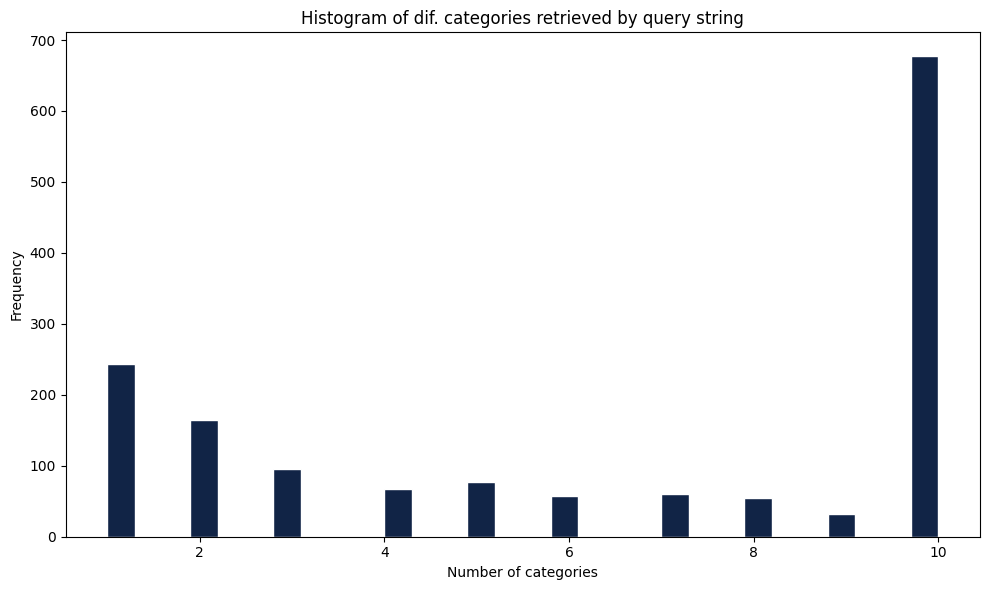

In [19]:
# Create histogram of number of categories by string query
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(catcountbystring['count'], bins=30, color='#112446', edgecolor='white')
    plt.title('Histogram of dif. categories retrieved by query string')
    plt.xlabel('Number of categories')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib not available, skipping visualization")

In [20]:
# Delete "Category:" string to match and compare with query string
categories_wikipedia['category'] = categories_wikipedia['title'].str.replace('Category:', '', regex=False)

In [21]:
def calculate_jaccard_qgram(s1, s2, q=3):
    """Calculate Jaccard distance using q-grams (similar to R stringdist with method='jaccard')"""
    if pd.isna(s1) or pd.isna(s2):
        return np.nan
    s1, s2 = str(s1).lower(), str(s2).lower()
    return 1 - textdistance.jaccard.normalized_similarity(s1, s2)

def calculate_levenshtein(s1, s2):
    """Calculate Levenshtein distance"""
    if pd.isna(s1) or pd.isna(s2):
        return np.nan
    return textdistance.levenshtein.distance(str(s1), str(s2))

In [22]:
# Calculate Jaccard and Levenshtein distances
print("Calculating distances (this may take a moment)...")

categories_wikipedia['jac'] = categories_wikipedia.apply(
    lambda row: calculate_jaccard_qgram(row['category'], row['query_string']), axis=1
)

categories_wikipedia['lev'] = categories_wikipedia.apply(
    lambda row: calculate_levenshtein(row['category'], row['query_string']), axis=1
)

print("Distance calculations complete")
categories_wikipedia[['category', 'query_string', 'jac', 'lev']].head(10)

Calculating distances (this may take a moment)...
Distance calculations complete


,category,query_string,jac,lev
0,Axioms of set theory,theory of language,0.538462,15
1,Programming language researchers,theory of language,0.611111,22
2,Theories of language,theory of language,0.190476,4
3,Philosophy of language,theory of language,0.400000,7
4,Academic programming languages,theory of language,0.628571,18
5,Programming languages conferences,theory of language,0.583333,23
6,The Big Bang Theory,theory of language,0.458333,14
7,Programming languages,theory of language,0.607143,11
8,Knot stubs,theory of language,0.782609,15
9,Logic stubs,theory of language,0.739130,15


In [23]:
# Category count for wordcloud
cat_count = categories_wikipedia.groupby('category').size().reset_index(name='n')
print(f"Unique categories: {len(cat_count)}")
cat_count.nlargest(20, 'n')

Unique categories: 1266


,category,n
1224,WikiProject Game theory participants,206
998,Science and Technology Publishing academic jou...,104
848,Philosophy of language,101
1073,Statistics educators,100
13,Academic and Scientific Publishing academic jo...,97
299,Design,91
1158,Theories of language,88
132,Canadian Research Publication academic journals,80
34,American Research Publications academic journals,70
410,Fellows of the Institute of Mathematical Stati...,67


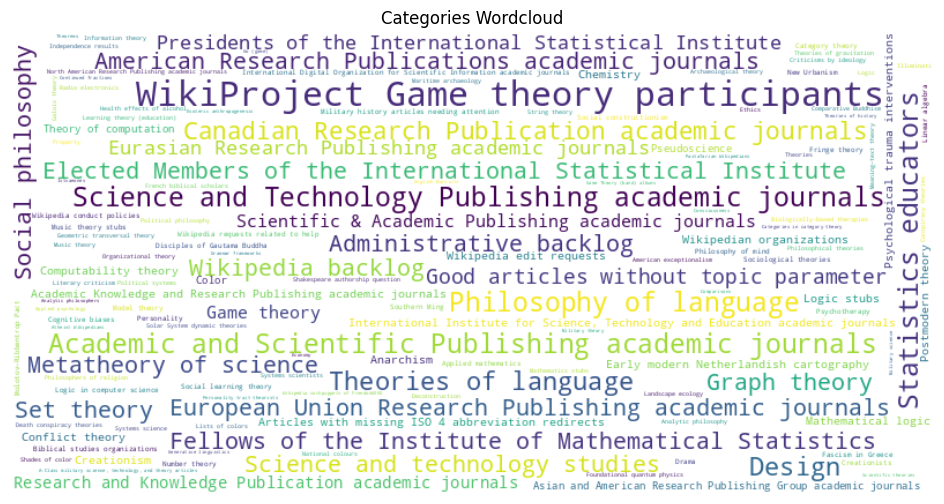

In [24]:
# Generate wordcloud (optional)
try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    
    # Create word frequencies dict
    word_freq = dict(zip(cat_count['category'], cat_count['n']))
    
    # Filter to categories with min frequency
    word_freq = {k: v for k, v in word_freq.items() if v >= 5}
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=200
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Categories Wordcloud')
    plt.show()
except ImportError:
    print("wordcloud library not available, skipping visualization")

In [25]:
# Filter categories by Jaccard distance
df_filtered = categories_wikipedia[categories_wikipedia['jac'] < 0.6].copy()
print(f"After jac < 0.6 filter: {len(df_filtered)} rows")

After jac < 0.6 filter: 4242 rows


In [26]:
# Filter by strange keywords found in wordcloud
exclude_pattern = r'WikiProject|Wikipedia|[C|c]onspiracy|Christ|[M|m]ilitary|articles|journals|missing|Satanic|[T|t]errorism|abuse|backlog|Lists|albums'
snippet_exclude = r'[C|c]onspiracy|[T|t]elevision|Nazis'

df_filtered = categories_wikipedia[
    (categories_wikipedia['jac'] < 0.6) &
    (~categories_wikipedia['category'].str.contains(exclude_pattern, regex=True, na=False)) &
    (~categories_wikipedia['snippet'].str.contains(snippet_exclude, regex=True, na=False))
].copy()

print(f"After filtering: {len(df_filtered)} rows")

After filtering: 3705 rows


In [27]:
# Save filtered categories
output_file = get_file_path("3_wikicategories_distances_filtered_rerun.csv")
df_filtered.to_csv(output_file, index=False)
print(f"Saved filtered categories to {output_file}")

Saved filtered categories to /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/data/3_wikicategories_distances_filtered_rerun.csv


## Step 4: Search Wikidata

Replication of `4search_wikidata.R`

This step searches Wikidata for humans in Wikipedia categories.

In [28]:
def query_wikidata(query):
    """Query Wikidata SPARQL endpoint"""
    url = "https://query.wikidata.org/sparql"
    headers = {'Accept': 'application/json'}
    
    try:
        response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
        response.raise_for_status()
        data = response.json()
        
        results = data.get('results', {}).get('bindings', [])
        return [{
            'item': r.get('item', {}).get('value', ''),
            'itemLabel': r.get('itemLabel', {}).get('value', '')
        } for r in results]
    except Exception as e:
        print(f"Query error: {e}")
        return []

In [29]:
def cat_query(category):
    """Create SPARQL query to search humans inside a Wikipedia category"""
    return f'''SELECT ?item ?itemLabel WHERE {{
  BIND("{category}" as ?category)
  SERVICE wikibase:mwapi {{
     bd:serviceParam wikibase:endpoint "en.wikipedia.org";
                     wikibase:api "Generator";
                     mwapi:generator "categorymembers";
                     mwapi:gcmtitle ?category.
     ?item wikibase:apiOutputItem mwapi:item.
  }} 
  FILTER BOUND (?item)
  FILTER EXISTS {{
    ?article schema:about ?item .
    ?item wdt:P31 wd:Q5.
  }}
SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}    
}}'''

In [30]:
# Load filtered data
if os.path.exists(get_file_path("3_wikicategories_distances_filtered.csv")):
    data = pd.read_csv(get_file_path("3_wikicategories_distances_filtered.csv"))
else:
    data = pd.read_csv(get_file_path("3_wikicategories_distances_filtered_rerun.csv"))

print(f"Loaded {len(data)} filtered categories")

Loaded 477 filtered categories


In [31]:
# Check if we already have the Wikidata humans data
humans_file = get_file_path("4_theorystrings_categories_humans.csv")

if os.path.exists(humans_file):
    print(f"Loading existing Wikidata humans from {humans_file}")
    df_humans = pd.read_csv(humans_file)
else:
    print("Querying Wikidata (this may take a while)...")
    
    # Get unique category titles
    queries_titles = data['title'].unique().tolist()
    print(f"Querying {len(queries_titles)} unique categories")
    
    all_results = []
    for i, title in enumerate(queries_titles):
        if i % 50 == 0:
            print(f"Processing {i}/{len(queries_titles)}...")
        
        query = cat_query(title)
        results = query_wikidata(query)
        
        for r in results:
            r['category'] = title
            all_results.append(r)
    
    df_humans = pd.DataFrame(all_results)
    df_humans.to_csv(humans_file, index=False)
    print(f"Saved {len(df_humans)} results to {humans_file}")

print(f"Humans data shape: {df_humans.shape}")
df_humans.head()

Loading existing Wikidata humans from /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/original_project/data/4_theorystrings_categories_humans.csv
Humans data shape: (2411, 3)


,category,item,itemLabel
0,Category:Philosophy of language,http://www.wikidata.org/entity/Q4532287,Mikhail Epstein
1,Category:Philosophy of language,http://www.wikidata.org/entity/Q55760938,Rebecca Roache
2,Category:Communication theorists,http://www.wikidata.org/entity/Q71488,Friedemann Schulz von Thun
3,Category:Communication theorists,http://www.wikidata.org/entity/Q76357,Jürgen Habermas
4,Category:Communication theorists,http://www.wikidata.org/entity/Q90586,Karl Küpfmüller


In [32]:
# Get unique humans
df_unique = df_humans.drop_duplicates(subset=['itemLabel']).copy()
if 'category' in df_unique.columns:
    df_unique = df_unique.drop(columns=['category'])

print(f"Unique humans: {len(df_unique)}")

# Save unique humans
unique_output_file = get_file_path("4_theorystrings_categories_humans_unique.csv")
df_unique.to_csv(unique_output_file, index=False)
print(f"Saved unique humans to {unique_output_file}")

Unique humans: 2219
Saved unique humans to /Users/zleblanc/is597_2026/week2_code/conceptual_forays/replication_code/original_project/data/4_theorystrings_categories_humans_unique.csv


## Step 5: Explore Theorists

Replication of `5explore_theorists.R`

In [33]:
# Check if extended data exists
extended_file = get_file_path("4_theory_dictionary_wikidata_extended.csv")

if os.path.exists(extended_file):
    data = pd.read_csv(extended_file)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    
    print(f"Loaded extended data with {len(data)} rows")
    print(f"Columns: {data.columns.tolist()}")
else:
    # Use the humans data we have
    data = pd.read_csv(get_file_path("4_theorystrings_categories_humans.csv"))
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(f"Using humans data with {len(data)} rows")
    print(f"Columns: {data.columns.tolist()}")

Using humans data with 2411 rows
Columns: ['category', 'item', 'itemlabel']


In [34]:
# Display first few rows
data.head()

,category,item,itemlabel
0,Category:Philosophy of language,http://www.wikidata.org/entity/Q4532287,Mikhail Epstein
1,Category:Philosophy of language,http://www.wikidata.org/entity/Q55760938,Rebecca Roache
2,Category:Communication theorists,http://www.wikidata.org/entity/Q71488,Friedemann Schulz von Thun
3,Category:Communication theorists,http://www.wikidata.org/entity/Q76357,Jürgen Habermas
4,Category:Communication theorists,http://www.wikidata.org/entity/Q90586,Karl Küpfmüller


In [35]:
# Explore distinct items - eliminate duplicates
if 'wikidata_id' in data.columns:
    unique_data = data.drop_duplicates(subset=['wikidata_id'])
    id_col = 'wikidata_id'
elif 'item' in data.columns:
    unique_data = data.drop_duplicates(subset=['item'])
    id_col = 'item'
else:
    unique_data = data.drop_duplicates(subset=['itemlabel'])
    id_col = 'itemlabel'

print(f"Unique persons: {len(unique_data)}")

Unique persons: 2219


In [36]:
# Explore genders if available
if 'sex_or_gender' in unique_data.columns:
    print("\nGender distribution:")
    print(unique_data['sex_or_gender'].value_counts())

In [37]:
# Explore countries if available
if 'country_of_citizenship' in unique_data.columns:
    print("\nTop countries of citizenship:")
    print(unique_data['country_of_citizenship'].value_counts().head(20))

In [38]:
# Summary statistics
print("\n=== Summary ===")
print(f"Total records: {len(data)}")
print(f"Unique persons: {len(unique_data)}")

if 'category' in data.columns:
    print(f"Unique categories: {data['category'].nunique()}")
    
    # Top categories by number of persons
    print("\nTop categories by person count:")
    print(data.groupby('category').size().sort_values(ascending=False).head(10))


=== Summary ===
Total records: 2411
Unique persons: 2219
Unique categories: 92

Top categories by person count:
category
Category:Marxist theorists              284
Category:Film theorists                 201
Category:Control theorists              164
Category:Mass media theorists           160
Category:Critical theorists             157
Category:German music theorists         113
Category:Architectural theoreticians    108
Category:Communication theorists         83
Category:Literary theorists              81
Category:Feminist theorists              63
dtype: int64


## Summary

This notebook has replicated the following R scripts in Python:

1. **1preprocessingdata.R** - Merged and cleaned theory strings from multiple sources
2. **2_query_wikipedia.py** - Queried Wikipedia API for categories (already Python, updated)
3. **3jac_distance_categories.R** - Calculated Jaccard distances and filtered categories
4. **4search_wikidata.R** - Searched Wikidata for humans in categories
5. **5explore_theorists.R** - Explored theorist demographics

All output files are saved in the `../data` directory.